In [4]:
# Основные библиотеки для работы с данными
import pandas as pd
import numpy as np

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams

# Настройка отображения
plt.style.use('default')
rcParams['figure.figsize'] = (12, 8)
rcParams['font.size'] = 12

# Настройка pandas для лучшего отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

df = pd.read_csv("dataset_telemetry.csv")
# Преобразуем timestamp в datetime, если еще не сделано
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Извлекаем месяц и год
df['month'] = df['timestamp'].dt.to_period('M')  # или dt.strftime('%Y-%m')
df['year_month'] = df['timestamp'].dt.strftime('%Y-%m')

df.head(5)


,Unnamed: 0,userid,sessionid,timestamp,action,value,category,age,gender,city,month,year_month
0,0,user_10000,1,2021-12-30 12:28:45,category,0.0,Товары для детей,42,Ж,Красноярск,2021-12,2021-12
1,1,user_10000,1,2021-12-30 12:29:10,search,0.0,Товары для детей,42,Ж,Красноярск,2021-12,2021-12
2,2,user_10000,1,2021-12-30 12:29:25,product,0.0,Товары для детей,42,Ж,Красноярск,2021-12,2021-12
3,3,user_10000,1,2021-12-30 12:29:26,search,0.0,Товары для детей,42,Ж,Красноярск,2021-12,2021-12
4,4,user_10000,1,2021-12-30 12:29:34,search,0.0,Товары для детей,42,Ж,Красноярск,2021-12,2021-12


In [5]:
# Создаем копию данных для безопасности
df_analysis = df.copy()

# Преобразуем timestamp и добавляем месяц
df_analysis['timestamp'] = pd.to_datetime(df_analysis['timestamp'])
df_analysis['year'] = df_analysis['timestamp'].dt.year
df_analysis['month'] = df_analysis['timestamp'].dt.month
df_analysis['year_month'] = df_analysis['timestamp'].dt.strftime('%Y-%m')

# Вариант A: Стандартный ARPU
df_value_users = df_analysis.copy()

# Считаем ARPU
arpu_results = []
for month in sorted(df_value_users['year_month'].unique()):
    month_data = df_value_users[df_value_users['year_month'] == month]
    
    total_revenue = month_data['value'].sum()
    unique_payers = month_data['userid'].nunique()
    
    if unique_payers > 0:
        arpu = total_revenue / unique_payers
    else:
        arpu = 0
    
    arpu_results.append({
        'year_month': month,
        'total_revenue': total_revenue,
        'unique_payers': unique_payers,
        'ARPU': arpu,
        'avg_value_per_transaction': month_data['value'].mean() if len(month_data) > 0 else 0,
        'transactions_count': len(month_data)
    })

arpu_df = pd.DataFrame(arpu_results)

print("=" * 60)
print("ARPU по месяцам:")
print("=" * 60)
print(arpu_df.to_string(index=False))
print("\nСводная статистика:")
print(f"Средний ARPU за период: {arpu_df['ARPU'].mean():.2f}")
print(f"Максимальный ARPU: {arpu_df['ARPU'].max():.2f} ({arpu_df.loc[arpu_df['ARPU'].idxmax(), 'year_month']})")
print(f"Минимальный ARPU: {arpu_df['ARPU'].min():.2f} ({arpu_df.loc[arpu_df['ARPU'].idxmin(), 'year_month']})")

# Для каждого месяца считаем всех уникальных пользователей (не только плативших)
arpu_all_users = []

for month in sorted(df_analysis['year_month'].unique()):
    month_data = df_analysis[df_analysis['year_month'] == month]
    
    # Выручка за месяц
    month_revenue = month_data['value'].sum()
    
    # Все уникальные пользователи в месяце (даже те, кто ничего не купил)
    all_users = month_data['userid'].nunique()
    
    # Платящие пользователи
    paying_users = month_data[month_data['value'] > 0]['userid'].nunique()
    
    if all_users > 0:
        arpu_all = month_revenue / all_users
        arpu_paying = month_revenue / paying_users if paying_users > 0 else 0
    else:
        arpu_all = 0
        arpu_paying = 0
    
    arpu_all_users.append({
        'year_month': month,
        'total_revenue': month_revenue,
        'all_users': all_users,
        'paying_users': paying_users,
        'ARPU_all_users': arpu_all,
        'ARPU_paying_users': arpu_paying,
        'conversion_rate': (paying_users / all_users * 100) if all_users > 0 else 0
    })

arpu_complete_df = pd.DataFrame(arpu_all_users)

print("\n" + "=" * 80)
print("Расширенный анализ ARPU:")
print("=" * 80)
print(arpu_complete_df.to_string(index=False))

ARPU по месяцам:
year_month  total_revenue  unique_payers          ARPU  avg_value_per_transaction  transactions_count
   2021-12   7.424609e+07           2415  30743.724141                2482.233753               29911
   2022-01   5.169183e+08           2500 206767.317589                2458.378327              210268
   2022-02   3.690424e+08           2500 147616.950576                1933.454757              190872
   2022-03   4.129888e+08           2500 165195.502684                1942.909630              212562
   2022-04   3.960662e+08           2500 158426.490256                1943.730680              203766
   2022-05   4.071707e+08           2500 162868.277956                1932.851802              210658
   2022-06   3.948901e+08           2500 157956.052544                1936.238981              203947
   2022-07   4.094091e+08           2500 163763.657128                1957.116224              209190
   2022-08   4.059862e+08           2500 162394.466879           

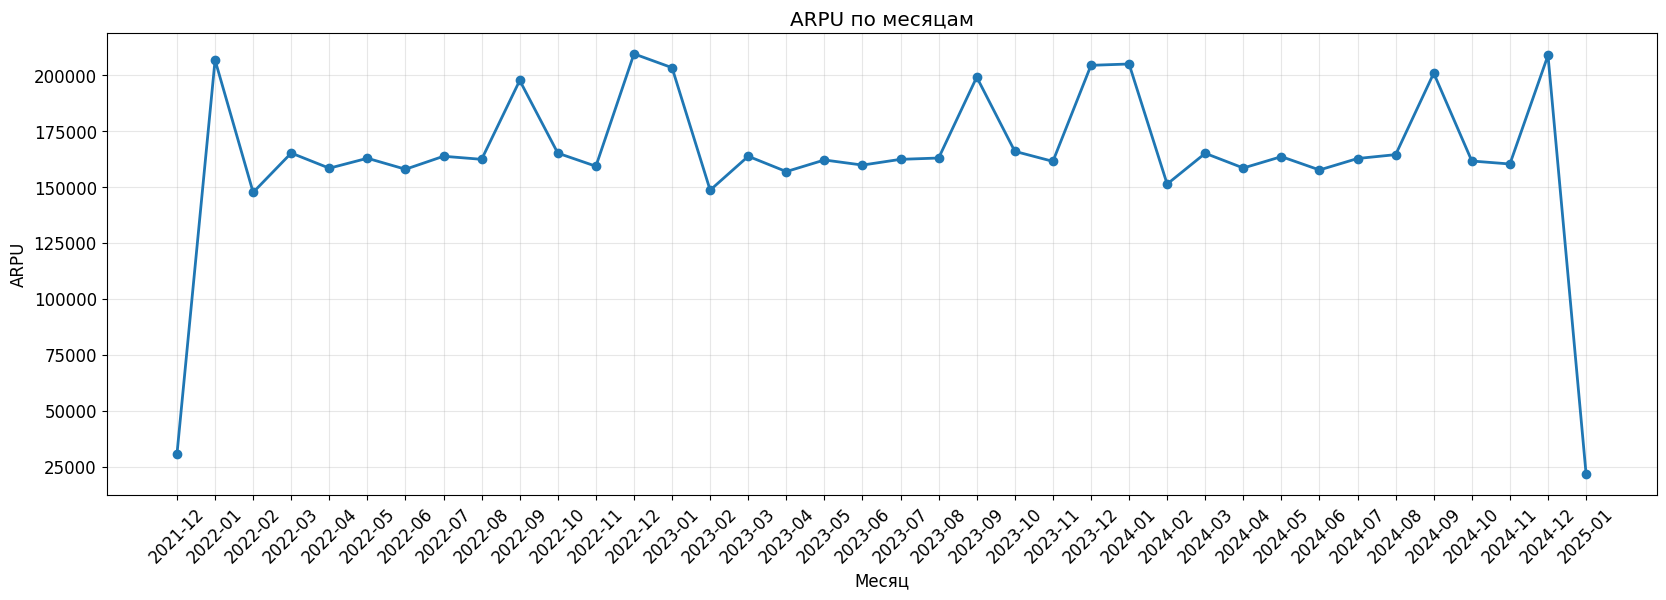

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 6))

# График 1: ARPU по месяцам
plt.subplot(1, 1, 1)
plt.plot(arpu_df['year_month'], arpu_df['ARPU'], marker='o', linewidth=2)
plt.title('ARPU по месяцам')
plt.xlabel('Месяц')
plt.ylabel('ARPU')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)





/var/folders/6x/h8znjt7j67z0np93fhbjn46r0000gn/T/ipykernel_2145/3337798331.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(arpu_df['year_month'], rotation=45)


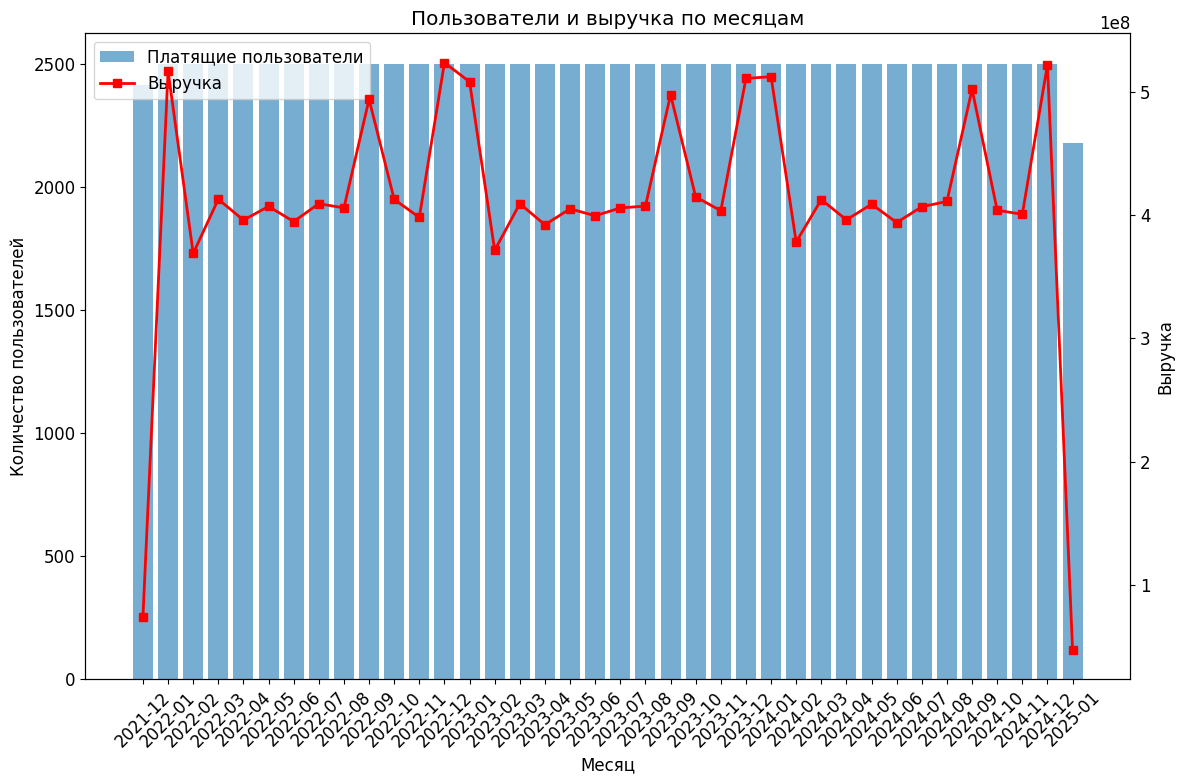

In [7]:
# График 2: Количество платящих пользователей и выручка
plt.subplot(1, 1, 1)
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.bar(arpu_df['year_month'], arpu_df['unique_payers'], alpha=0.6, label='Платящие пользователи')
ax2.plot(arpu_df['year_month'], arpu_df['total_revenue'], color='red', marker='s', 
         linewidth=2, label='Выручка')

ax1.set_xlabel('Месяц')
ax1.set_ylabel('Количество пользователей')
ax2.set_ylabel('Выручка')
ax1.set_title('Пользователи и выручка по месяцам')
ax1.set_xticklabels(arpu_df['year_month'], rotation=45)

# Объединение легенд
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

In [8]:

# Предполагаем, что df уже загружен и timestamp преобразован
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['year_month'] = df['timestamp'].dt.strftime('%Y-%m')

# ARPPU расчет
arppu_results = []

for month in sorted(df['year_month'].unique()):
    month_data = df[df['year_month'] == month]
    
    # 1. Фильтруем только платящих пользователей (value > 0)
    paying_data = month_data[month_data['value'] > 0]
    
    if len(paying_data) > 0:
        # 2. Общая выручка за месяц
        total_revenue = paying_data['value'].sum()
        
        # 3. Уникальные платящие пользователи
        paying_users = paying_data['userid'].nunique()
        
        # 4. ARPPU
        arppu = total_revenue / paying_users
        
        # Дополнительные метрики
        avg_transactions_per_user = len(paying_data) / paying_users
        avg_value_per_transaction = paying_data['value'].mean()
        
        arppu_results.append({
            'year_month': month,
            'total_revenue': total_revenue,
            'paying_users': paying_users,
            'ARPPU': arppu,
            'transactions_count': len(paying_data),
            'avg_transactions_per_user': avg_transactions_per_user,
            'avg_value_per_transaction': avg_value_per_transaction
        })
    else:
        arppu_results.append({
            'year_month': month,
            'total_revenue': 0,
            'paying_users': 0,
            'ARPPU': 0,
            'transactions_count': 0,
            'avg_transactions_per_user': 0,
            'avg_value_per_transaction': 0
        })

arppu_df = pd.DataFrame(arppu_results)

print("=" * 80)
print("ARPPU (Average Revenue Per Paying User) по месяцам:")
print("=" * 80)
print(arppu_df.to_string(index=False))

ARPPU (Average Revenue Per Paying User) по месяцам:
year_month  total_revenue  paying_users         ARPPU  transactions_count  avg_transactions_per_user  avg_value_per_transaction
   2021-12   7.424609e+07          1433  51811.649546                3921                   2.736218               18935.499566
   2022-01   5.169183e+08          2496 207098.675470               27399                  10.977163               18866.319719
   2022-02   3.690424e+08          2494 147972.083577               24871                   9.972334               14838.260482
   2022-03   4.129888e+08          2494 165592.925706               28011                  11.231355               14743.806244
   2022-04   3.960662e+08          2497 158616.830453               26702                  10.693632               14832.829962
   2022-05   4.071707e+08          2492 163391.129571               27617                  11.082263               14743.480280
   2022-06   3.948901e+08          2490 158590.41420

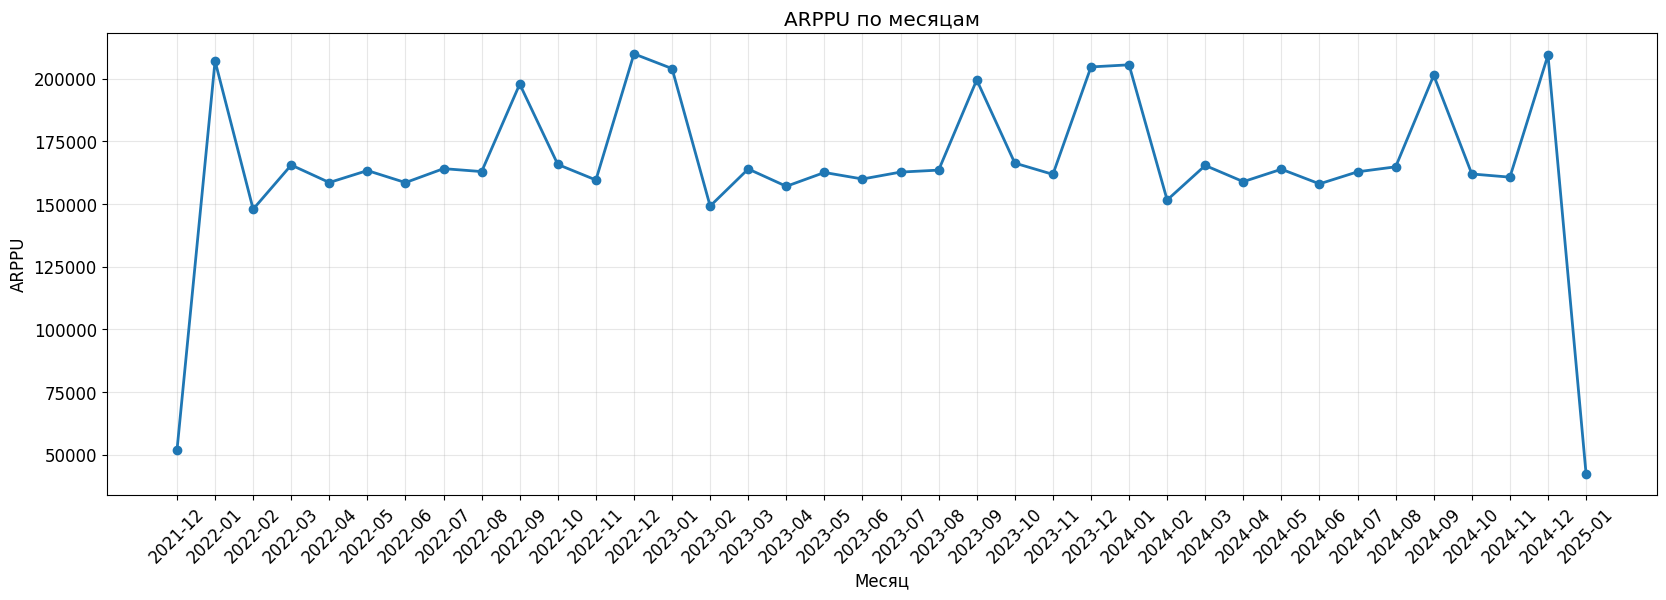

In [9]:
plt.figure(figsize=(20, 6))

# График 1: ARPPU по месяцам
plt.subplot(1, 1, 1)
plt.plot(arppu_df['year_month'], arppu_df['ARPPU'], marker='o', linewidth=2)
plt.title('ARPPU по месяцам')
plt.xlabel('Месяц')
plt.ylabel('ARPPU')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)


In [10]:
# Сначала считаем ARPU (все пользователи)
arpu_results = []

for month in sorted(df['year_month'].unique()):
    month_data = df[df['year_month'] == month]
    
    # Все пользователи в месяце
    all_users = month_data['userid'].nunique()
    
    # Выручка от платящих пользователей
    paying_data = month_data[month_data['value'] > 0]
    total_revenue = paying_data['value'].sum()
    paying_users = paying_data['userid'].nunique()
    
    # ARPU (все пользователи)
    arpu = total_revenue / all_users if all_users > 0 else 0
    
    # ARPPU (только платящие)
    arppu = total_revenue / paying_users if paying_users > 0 else 0
    
    arpu_results.append({
        'year_month': month,
        'all_users': all_users,
        'paying_users': paying_users,
        'conversion_rate': (paying_users / all_users * 100) if all_users > 0 else 0,
        'total_revenue': total_revenue,
        'ARPU': arpu,
        'ARPPU': arppu,
        'difference': arppu - arpu
    })

comparison_df = pd.DataFrame(arpu_results)

print("\n" + "=" * 90)
print("Сравнение ARPU и ARPPU:")
print("=" * 90)
print(comparison_df.to_string(index=False))

# Сводная статистика
print("\n📊 Сводная статистика за весь период:")
print(f"Средний ARPU: {comparison_df['ARPU'].mean():.2f}")
print(f"Средний ARPPU: {comparison_df['ARPPU'].mean():.2f}")
print(f"Средняя конверсия в платящих: {comparison_df['conversion_rate'].mean():.1f}%")
print(f"Разница ARPPU - ARPU: {comparison_df['ARPPU'].mean() - comparison_df['ARPU'].mean():.2f}")


Сравнение ARPU и ARPPU:
year_month  all_users  paying_users  conversion_rate  total_revenue          ARPU         ARPPU   difference
   2021-12       2415          1433        59.337474   7.424609e+07  30743.724141  51811.649546 21067.925406
   2022-01       2500          2496        99.840000   5.169183e+08 206767.317589 207098.675470   331.357881
   2022-02       2500          2494        99.760000   3.690424e+08 147616.950576 147972.083577   355.133001
   2022-03       2500          2494        99.760000   4.129888e+08 165195.502684 165592.925706   397.423022
   2022-04       2500          2497        99.880000   3.960662e+08 158426.490256 158616.830453   190.340197
   2022-05       2500          2492        99.680000   4.071707e+08 162868.277956 163391.129571   522.851615
   2022-06       2500          2490        99.600000   3.948901e+08 157956.052544 158590.414201   634.361657
   2022-07       2500          2494        99.760000   4.094091e+08 163763.657128 164157.635453   393.9

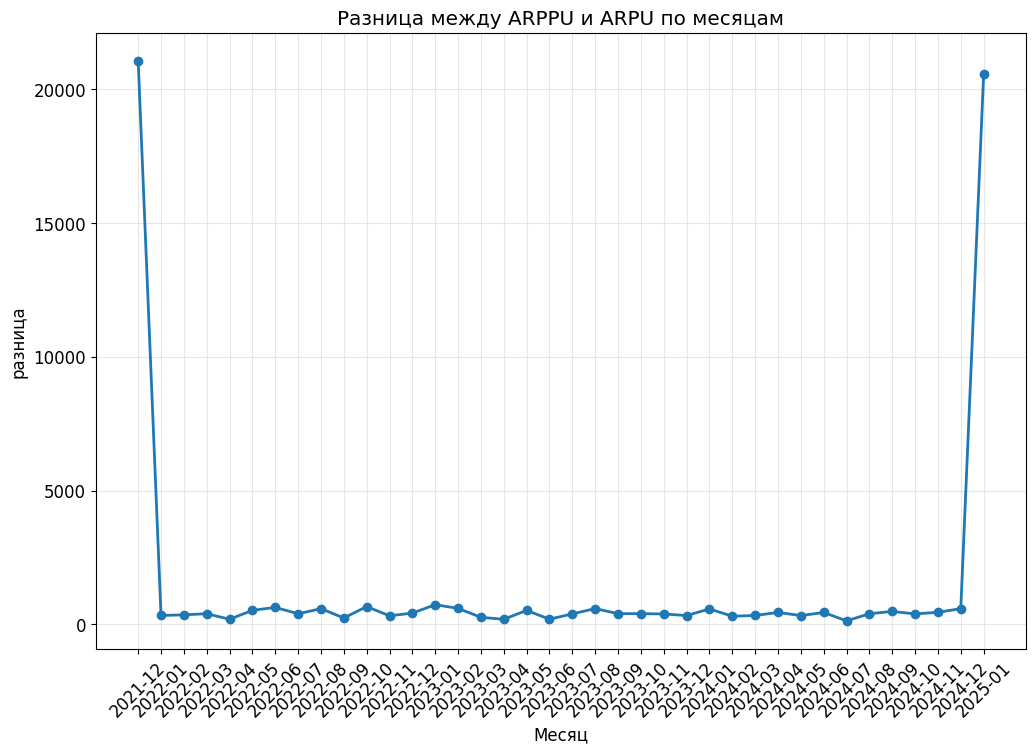

In [11]:
import numpy as np

plt.plot(comparison_df['year_month'], comparison_df['difference'], marker='o', linewidth=2)
plt.title('Разница между ARPPU и ARPU по месяцам')
plt.xlabel('Месяц')
plt.ylabel('разница')
plt.xticks(rotation=45)

plt.grid(True, alpha=0.3)

In [12]:
arpu_by_gender = []

for month in sorted(df['year_month'].unique()):
    month_data = df[df["year_month"] == month]

    for gender in df['gender'].unique():
        gender_data = month_data[month_data["gender"] == gender]
        # Все пользователи этого пола
        all_users = gender_data['userid'].nunique()
        paying_data = gender_data[gender_data["value"] > 0]
        total_revenue = paying_data["value"].sum()
        paying_users = paying_data["userid"].nunique()

        arpu = total_revenue / all_users
        arppu = total_revenue / paying_users
        conversion = paying_users / all_users * 100

        arpu_by_gender.append({
            'year_month': month,
                'gender': gender,
                'all_users': all_users,
                'paying_users': paying_users,
                'conversion_rate': conversion,
                'total_revenue': total_revenue,
                'ARPU': arpu,
                'ARPPU': arppu
        })

arpu_gender_df = pd.DataFrame(arpu_by_gender)

print("=" * 90)
print("ARPU по полу (гендеру):")
print("=" * 90)

print(arpu_gender_df.to_string(index=False))



        
        



ARPU по полу (гендеру):
year_month gender  all_users  paying_users  conversion_rate  total_revenue          ARPU         ARPPU
   2021-12      Ж       1392           833        59.841954   4.264741e+07  30637.506075  51197.369095
   2021-12      М       1023           600        58.651026   3.159869e+07  30888.255468  52664.475572
   2022-01      Ж       1445          1442        99.792388   2.951774e+08 204275.031014 204700.013742
   2022-01      М       1055          1054        99.905213   2.217409e+08 210180.923372 210380.336013
   2022-02      Ж       1445          1444        99.930796   2.100533e+08 145365.610208 145466.278913
   2022-02      М       1055          1050        99.526066   1.589891e+08 150700.539991 151418.161610
   2022-03      Ж       1445          1439        99.584775   2.388636e+08 165303.518332 165992.761633
   2022-03      М       1055          1055       100.000000   1.741252e+08 165047.557081 165047.557081
   2022-04      Ж       1445          1442       

In [13]:
# Pivot таблица для ARPU
arpu_pivot = arpu_gender_df.pivot_table(
    index='year_month',
    columns='gender',
    values=['ARPU', 'ARPPU', 'total_revenue', 'all_users'],
    aggfunc='first'
)

print("\n📅 ARPU по полу по месяцам:")
print("=" * 60)

# Распаковываем multi-index для лучшего отображения
for metric in ['ARPU', 'ARPPU', 'total_revenue']:
    if metric in arpu_pivot.columns.get_level_values(0):
        print(f"\n{metric}:")
        metric_df = arpu_pivot[metric].copy()
        print(metric_df.to_string())
    
# Разница в ARPU между полами
if 'ARPU' in arpu_pivot.columns.get_level_values(0):
    arpu_diff = arpu_pivot['ARPU'].copy()
    if len(arpu_diff.columns) > 1:
        # Находим две основные категории гендера
        genders = arpu_diff.columns[:2]
        arpu_diff['difference'] = arpu_diff[genders[0]] - arpu_diff[genders[1]]
        arpu_diff['higher_gender'] = arpu_diff.apply(
            lambda x: genders[0] if x[genders[0]] > x[genders[1]] else genders[1], 
            axis=1
        )
        
        print("\n📊 Разница в ARPU между полами:")
        print(arpu_diff[['difference', 'higher_gender']].to_string())


📅 ARPU по полу по месяцам:

ARPU:
gender                  Ж              М
year_month                              
2021-12      30637.506075   30888.255468
2022-01     204275.031014  210180.923372
2022-02     145365.610208  150700.539991
2022-03     165303.518332  165047.557081
2022-04     159226.857516  157330.252635
2022-05     161145.469855  165227.953507
2022-06     157036.750083  159215.191934
2022-07     161316.823945  167115.006844
2022-08     160346.487361  165199.519394
2022-09     196544.931463  199145.656185
2022-10     164652.643377  165848.112227
2022-11     157944.801040  161165.077889
2022-12     208855.774924  210456.752373
2023-01     204925.663281  201171.357836
2023-02     150108.556844  146575.513118
2023-03     165791.054381  160973.389697
2023-04     159316.304125  153627.941782
2023-05     162295.750159  161839.201147
2023-06     157891.451668  162470.341156
2023-07     162363.255239  162420.794578
2023-08     164513.079775  160872.671777
2023-09     197939.124

/var/folders/6x/h8znjt7j67z0np93fhbjn46r0000gn/T/ipykernel_2145/1006247892.py:83: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/6x/h8znjt7j67z0np93fhbjn46r0000gn/T/ipykernel_2145/1006247892.py:83: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/6x/h8znjt7j67z0np93fhbjn46r0000gn/T/ipykernel_2145/1006247892.py:83: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/6x/h8znjt7j67z0np93fhbjn46r0000gn/T/ipykernel_2145/1006247892.py:83: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
/Users/konstantin_sukh/Desktop/progr/big_data_yandex/.venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/konstantin_sukh/Desktop/progr/big_data

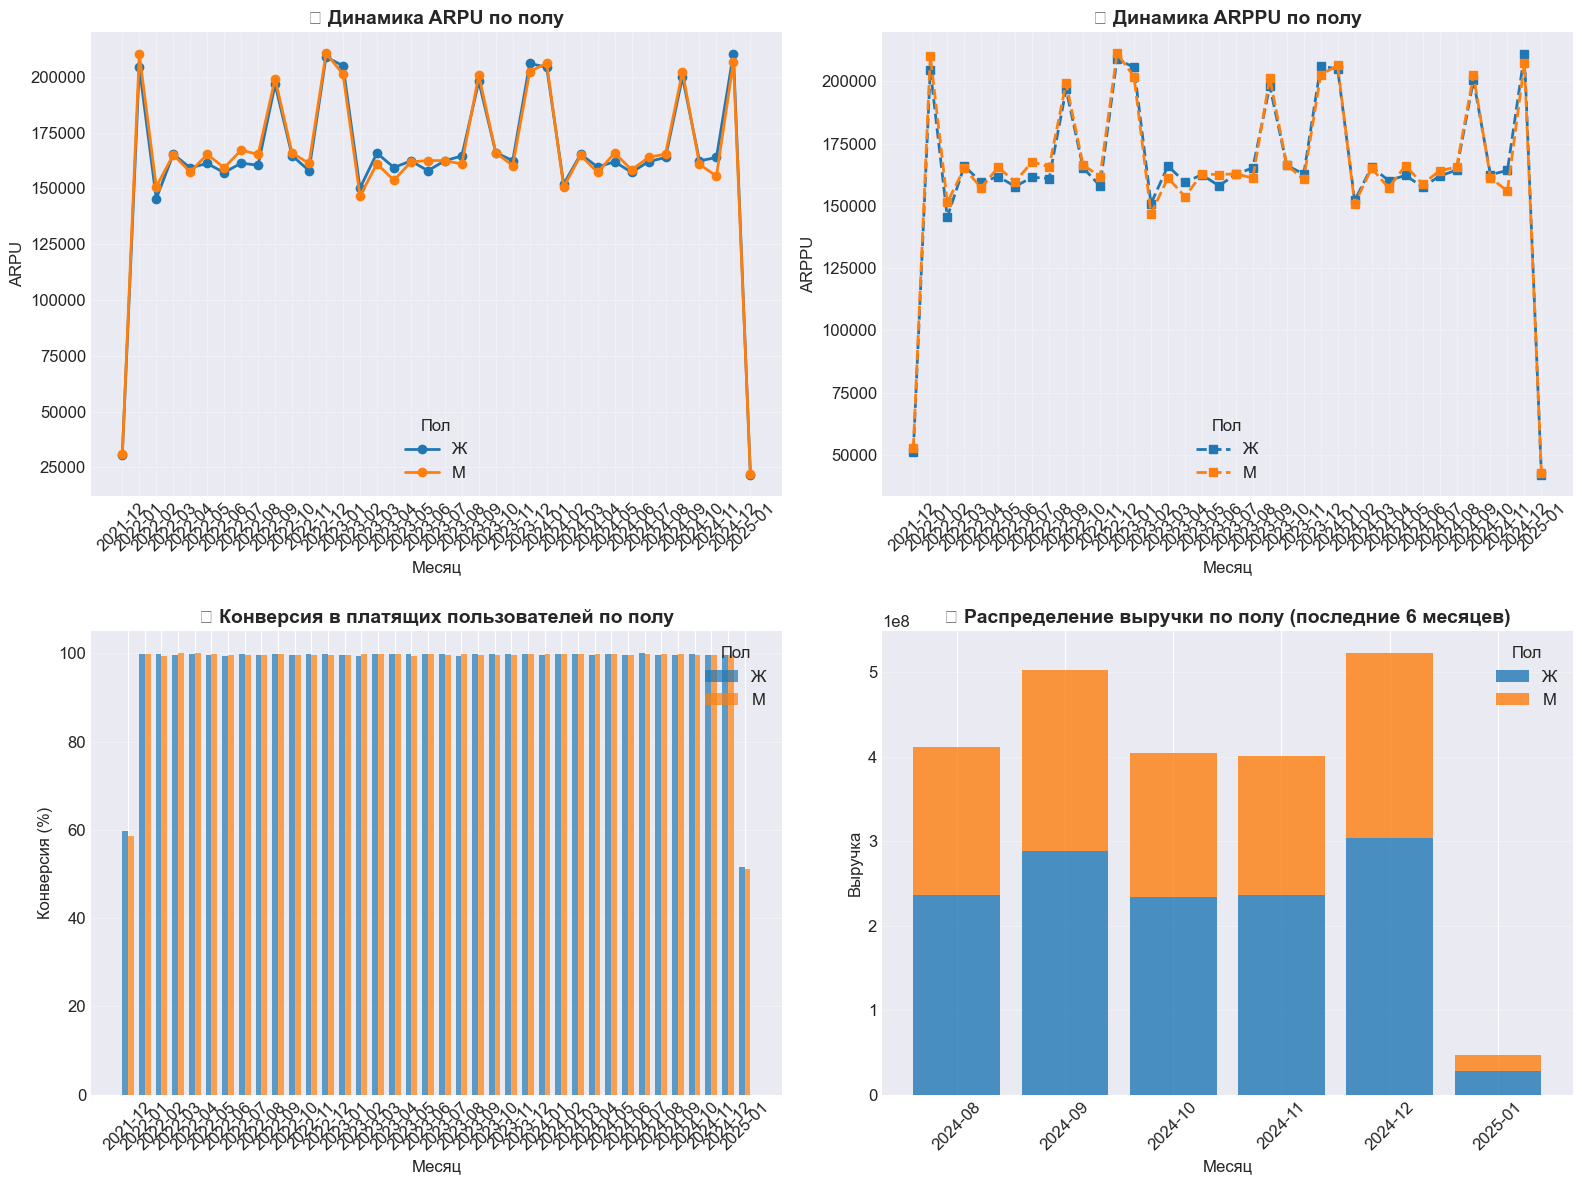

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Устанавливаем стиль
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# График 1: Динамика ARPU по полу
for gender in arpu_gender_df['gender'].unique():
    gender_data = arpu_gender_df[arpu_gender_df['gender'] == gender].sort_values('year_month')
    axes[0, 0].plot(gender_data['year_month'], gender_data['ARPU'], 
                   marker='o', linewidth=2, label=gender, markersize=6)

axes[0, 0].set_title('📈 Динамика ARPU по полу', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Месяц')
axes[0, 0].set_ylabel('ARPU')
axes[0, 0].legend(title='Пол')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# График 2: Динамика ARPPU по полу
for gender in arpu_gender_df['gender'].unique():
    gender_data = arpu_gender_df[arpu_gender_df['gender'] == gender].sort_values('year_month')
    axes[0, 1].plot(gender_data['year_month'], gender_data['ARPPU'], 
                   marker='s', linewidth=2, label=gender, markersize=6, linestyle='--')

axes[0, 1].set_title('💰 Динамика ARPPU по полу', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Месяц')
axes[0, 1].set_ylabel('ARPPU')
axes[0, 1].legend(title='Пол')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# График 3: Конверсия по полу
bar_width = 0.35
months = sorted(arpu_gender_df['year_month'].unique())
x = range(len(months))

for idx, gender in enumerate(arpu_gender_df['gender'].unique()):
    gender_data = arpu_gender_df[arpu_gender_df['gender'] == gender].sort_values('year_month')
    positions = [i + bar_width * idx for i in x]
    axes[1, 0].bar(positions, gender_data['conversion_rate'], 
                  width=bar_width, label=gender, alpha=0.7)

axes[1, 0].set_title('📊 Конверсия в платящих пользователей по полу', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Месяц')
axes[1, 0].set_ylabel('Конверсия (%)')
axes[1, 0].set_xticks([i + bar_width/2 for i in x])
axes[1, 0].set_xticklabels(months, rotation=45)
axes[1, 0].legend(title='Пол')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# График 4: Доля выручки по полу
last_6_months = sorted(arpu_gender_df['year_month'].unique())[-6:]
recent_data = arpu_gender_df[arpu_gender_df['year_month'].isin(last_6_months)]

# Создаем stacked bar chart
months_sorted = sorted(recent_data['year_month'].unique())
bottom_values = [0] * len(months_sorted)

for gender in sorted(recent_data['gender'].unique()):
    gender_values = []
    for month in months_sorted:
        month_gender_data = recent_data[(recent_data['year_month'] == month) & 
                                        (recent_data['gender'] == gender)]
        if len(month_gender_data) > 0:
            gender_values.append(month_gender_data['total_revenue'].iloc[0])
        else:
            gender_values.append(0)
    
    axes[1, 1].bar(months_sorted, gender_values, bottom=bottom_values, 
                  label=gender, alpha=0.8)
    bottom_values = [bottom + value for bottom, value in zip(bottom_values, gender_values)]

axes[1, 1].set_title('🎯 Распределение выручки по полу (последние 6 месяцев)', 
                    fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Месяц')
axes[1, 1].set_ylabel('Выручка')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].legend(title='Пол')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [16]:
arpu_by_category = []

for month in sorted(df['year_month'].unique()):
    month_data = df[df["year_month"] == month]

    for category in df['category'].unique():
        category_data = month_data[month_data["category"] == category]
        # Все пользователи этого пола
        all_users = category_data['userid'].nunique()
        paying_data = category_data[category_data["value"] > 0]
        total_revenue = paying_data["value"].sum()
        paying_users = paying_data["userid"].nunique()
        if not all_users:
            continue

        arpu = total_revenue / all_users
        arppu = total_revenue / paying_users
        #conversion = paying_users / all_users * 100

        arpu_by_category.append({
            'year_month': month,
                'category': category,
                'all_users': all_users,
                'paying_users': paying_users,
                #'conversion_rate': conversion,
                'total_revenue': total_revenue,
                'ARPU': arpu,
                'ARPPU': arppu
        })

arpu_category_df = pd.DataFrame(arpu_by_category)

print("=" * 90)
print("ARPU по категории:")
print("=" * 90)

print(arpu_category_df.to_string(index=False))



ARPU по категории:
year_month                      category  all_users  paying_users  total_revenue         ARPU        ARPPU
   2021-12              Товары для детей       1481           395   1.145702e+07  7736.001697 29005.110161
   2021-12              Авто/мото товары       1314           369   1.001891e+07  7624.741427 27151.518254
   2021-12 Электроника и бытовая техника       1395           389   1.058555e+07  7588.207966 27212.211085
   2021-12                Одежда и обувь       1509           409   1.133589e+07  7512.185686 27716.108069
   2021-12            Красота и здоровье       1406           386   1.147343e+07  8160.332273 29723.904599
   2021-12      Продовольственные товары       1447           399   1.081363e+07  7473.137100 27101.828028
   2022-01              Товары для детей       2495          1828   8.618965e+07 34544.948934 47149.697806
   2022-01              Авто/мото товары       2487          1731   7.424520e+07 29853.316437 42891.506632
   2022-01 Электро